# Notebook to extract place cell information from the dataset

Import the necessary libraries (including the `pynwb` package)

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pynwb

### File reading and information

In [2]:
# Set filepath name to read it with NWB
filepath = Path("data\TestPlitt", "sub-R2_ses-20190219T210000_behavior+ophys_small.nwb")

read_io = pynwb.NWBHDF5IO(filepath, "r")
read_nwbfile = read_io.read()


In [3]:
# Print out file information. This would be from one session
print("Subject info:")
for key, value in read_nwbfile.subject.fields.items():
    print(f"    {key:13}: {value}")

print("\nSession info:")    
print(f"    date/time  : {read_nwbfile.session_start_time}")
print(f"    description: {read_nwbfile.session_description}")

Subject info:
    genotype     : CaMKII-cre hemizygous
    sex          : MALE
    species      : Mus musculus
    subject_id   : R2
    weight       : 23.0 g
    date_of_birth: 2018-11-06 21:00:00-08:00

Session info:
    date/time  : 2019-02-19 21:00:00-08:00
    description: TwoTower_foraging_002_003


### Store some key information

In [4]:
# Neuronal traces from ROIs
ROI_traces = read_nwbfile.processing["ophys"]["Fluorescence"]["RoiResponseSeries"].data
nFrames, nNeurons = ROI_traces.shape
print("{} frames x {} neurons".format(*ROI_traces.shape))

# Deconvolved activity traces
deconvTraces = read_nwbfile.processing["ophys"]["Fluorescence"]["Deconvolved"].data


31932 frames x 2050 neurons


In [5]:
# information of start time for every trial
tstartData = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"]["tstart"].data[()]
nTrials = int(sum(tstartData))
print("Number of trials for this session is: ", nTrials)

# Matrix that stores where the starting points for each trial is
# Useful to divide trials
startIndices = np.where(tstartData)[0]

Number of trials for this session is:  120


In [6]:
# morph value for each trial (total morph taken as base morph + jitter)
baseMorph = read_nwbfile.stimulus["morph"].data[()]
wallJitter = read_nwbfile.stimulus["wallJitter"].data[()]
totalMorph = baseMorph + wallJitter

# Position of the rat over the session
position = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"]["pos"].data[()]

<div class="alert alert-block alert-info"> Important to note we will be using the <b>baseMorph</b> here. It will be used to classify the trials per morph (and get a place cell classification per session per morph value) </div>

#### Define function to positionally bin the data
might be a good idea to vectorize this function

In [8]:
def positionalBin(data, pos):
    bins = np.arange(0, 4.51, 0.1)
    avgResp = np.zeros(len(bins))
    counterArr = np.zeros(len(bins))

    for i in range(len(bins)-1):
        counter = 0 # to keep track of how many data points, to average after accumulation
        for j in range(len(pos)):
            if (bins[i] <= pos[j] < bins[i+1]): # if the position falls within the interval
                avgResp[i] = avgResp[i] + data[j] # keep accumulating the fluoresence data points in this interval
                counter = counter + 1 # keeps track of how many data points are added to average in the end
        if counter != 0: # to avoid dividing by zero if there aren't any datapoints in a bin
            counterArr[i] = counter    # store the counter per positional bin 
            avgResp[i] = avgResp[i]/counter # gets average of the sum after all values in phi have been looped over
    return avgResp, counterArr


In [21]:
# Number of positional bins
nBins = 46

# Creating the dataframe with trials x bins
df = np.zeros([nTrials, nBins])
occp = np.zeros([nTrials, nBins])

# Which cell are we performing the binning on?
cellTrace = deconvTraces[:,0]

# Make sure to add data for last trial DONE
for i in range(nTrials):
    if i < nTrials - 1:
        l = int(startIndices[i])
        r = int(startIndices[i+1])
        df[i,:], occp[i,:] = positionalBin(cellTrace[l:r], position[l:r])
    else:
        l = int(startIndices[i])
        df[i,:], occp[i,:] = positionalBin(cellTrace[l:], position[l:])
    # df[i,:] = cellActivity/np.mean(cellActivity)



In [59]:
trialOccp = np.sum(occp[:,:], axis = 1)
partialOccp = occp / trialOccp.reshape(-1,1)

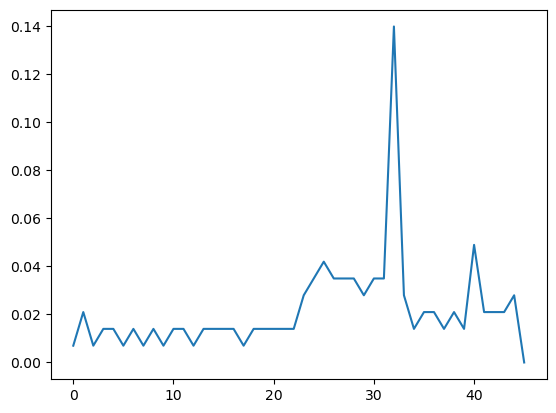

In [62]:
plt.plot(partialOccp[119,:])

### TO DO LIST:
- Return positional occupancy rate per trial (DONE, we have total time per trial in a session and partial occupancy of each bin within a trial)
- Vectorize the binning function
- Binning function can handle all the neurons in the session
- SI calculation with new occupancy rate and aggregated neuronal activity per morph value and occupancy 

### Classify per morph value

The mathematical equation to identify a place cell is using a spatial information metric:

`SI = summ(p_j x lambda_j x log2(lambda_j/lambda))`

Where:
- p_j is the fractional occupancy of each bin j (how much time is spent in each bin)
- lambda_j is the average activity rate of a cell in position bin j 
- lambda is the position-averaged activity rate of the cell

We need to do this for each of the 5 seperate base morph values `S = 0, 0.25, 0.5, 0.75, 1` 

In [133]:
# Setting up the aggregation of trials with the same base morph
baseMorphList = baseMorph[startIndices]; # Gives an array of size 120 (number of trials) with each element representing the
# base morph for the corresponding trial

base0 = np.where(baseMorphList == 0   )[0]
base1 = np.where(baseMorphList == 0.25)[0]
base2 = np.where(baseMorphList == 0.5 )[0]
base3 = np.where(baseMorphList == 0.75)[0]
base4 = np.where(baseMorphList == 1   )[0]

print(len(base0), "trials of base morph 0")
print(len(base1), "trials of base morph 0.25")
print(len(base2), "trials of base morph 0.5")
print(len(base3), "trials of base morph 0.75")
print(len(base4), "trials of base morph 1")

30 trials of base morph 0
20 trials of base morph 0.25
20 trials of base morph 0.5
20 trials of base morph 0.75
30 trials of base morph 1


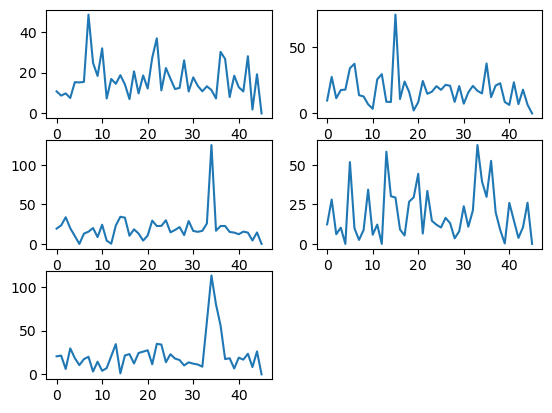

In [173]:
# Initializing the matrices for each base morph value, setting them up for aggregation

trialsBase0 = df[base0,:]
trialsBase1 = df[base1,:]
trialsBase2 = df[base2,:]
trialsBase3 = df[base3,:]
trialsBase4 = df[base4,:]

aggBase = np.zeros([5, nBins])
# Averaging across all trials with the same baseMorph
aggBase[0,:] = np.mean(trialsBase0, axis = 0)
aggBase[1,:] = np.mean(trialsBase1, axis = 0)
aggBase[2,:] = np.mean(trialsBase2, axis = 0)
aggBase[3,:] = np.mean(trialsBase3, axis = 0)
aggBase[4,:] = np.mean(trialsBase4, axis = 0)

plt.figure(1)
plt.subplot(3,2,1)
plt.plot(aggBase[0,:])
plt.subplot(3,2,2)
plt.plot(aggBase[1,:])
plt.subplot(3,2,3)
plt.plot(aggBase[2,:])
plt.subplot(3,2,4)
plt.plot(aggBase[3,:])
plt.subplot(3,2,5)
plt.plot(aggBase[4,:])


In [174]:
# Aggregation of partial occupancies for each base morph value (summing up occupancy per bin,
# dividing by total time spent in that base value)
aggOccBase = np.zeros([5,nBins])

aggOccBase[0,:] = np.sum(occp[base0,:], axis = 0) / np.sum(occp[base0,:])
aggOccBase[1,:] = np.sum(occp[base1,:], axis = 0) / np.sum(occp[base1,:])
aggOccBase[2,:] = np.sum(occp[base2,:], axis = 0) / np.sum(occp[base2,:])
aggOccBase[3,:] = np.sum(occp[base3,:], axis = 0) / np.sum(occp[base3,:])
aggOccBase[4,:] = np.sum(occp[base4,:], axis = 0) / np.sum(occp[base4,:])


In [175]:
# For one cell, 5 base morphs
SI = np.zeros(5)

for i in range(5):
    # position-averaged activity rate of the cell across the trial
    lmbda = np.mean(aggBase[i,:])
    logTerm = np.log2((aggBase[i,:]+1e-5)/lmbda) # + 1 necessary due to using deconv data (log2(0) = -inf)
    SIPre = (aggOccBase[i,:] * aggBase[i,:] * logTerm)
    SI[i] = np.sum(SIPre)
    

In [176]:
print(SI)

[ 2.6953898   3.43308762 24.34528691 10.48301013 24.5188198 ]


<font size = '3'> We can see that this cell carries the most information for base morph values of 0.5 and 1, somewhat for 0.75, and very little for 0.<br> This is in agreement with what we see graphically above. </font>


In [96]:
aTest = np.array([5, 1, 2, 4, 9, 3, 4, 5])
inds = np.where(aTest <5)[0]
print(np.sum(aTest[inds]))

14
